
Branin:

GP EI: exact versus approximate partial-order GP EI derivatives wrt **x1**, **x2**

In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=184bf2e0a913286564fdea903ed1691bd676d77f42ad5d15af7b803101f0de24
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
n_start_AcqFunc = 100 #multi-start iterations to avoid local optima in AcqFunc optimization


In [4]:
### Inputs:

func = 'Branin'
n_test = 500
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 5 # random initialisations
iters = 20
opt = True

In [5]:
### Objective Function - Branin(x) 2-D:

def objfunc(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        
# Constraints:
lb_x1 = -5 
ub_x1 = +10
lb_x2 = +0 
ub_x2 = +15

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_lb = 0.397887 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum


# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test)
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(-dKstar, self.alpha)
        ds = -2 * np.dot(-dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad

    def acqfunc_h(self, xnew, n_start=n_start_AcqFunc, eps=eps):
        f = self.acqfunc(xnew)[0]
        
        new_mean_h, new_var_h = self.GP.predict(xnew + eps, return_std=True)
        new_std_h = np.sqrt(new_var_h + eps)
        dm_h, ds_h = self.GP.AcqGrad(xnew + eps)
        f_h = self.A.d_eval(-self.tau, new_mean_h, new_std_h, ds=ds_h, dm=dm_h)[0]
        
        approx_grad = (-f_h - f)/eps
        return approx_grad


In [10]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [11]:
start_approx = time.time()
start_approx


1629284859.8016899

In [12]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.25533007 10.8048674 ]. 	  -56.52874004692151 	 -27.68166689936483
init   	 [-4.99828438  4.53498859]. 	  -172.66531086516164 	 -27.68166689936483
init   	 [-2.79866164  1.38507892]. 	  -102.58290348816024 	 -27.68166689936483
init   	 [-2.20609683  5.18341091]. 	  -28.868064601155666 	 -27.68166689936483
init   	 [0.95151211 8.08225101]. 	  -27.68166689936483 	 -27.68166689936483
1      	 [8.41909995 1.27566317]. 	  -5.089934878453152 	 -5.089934878453152
2      	 [10. 15.]. 	  -145.87219087939556 	 -5.089934878453152
3      	 [-5. 15.]. 	  -17.508299515778166 	 -5.089934878453152
4      	 [7.90355496 8.38355717]. 	  -57.03477656850546 	 -5.089934878453152
5      	 [3.09545804 0.        ]. 	  -5.749996691813506 	 -5.089934878453152
6      	 [ 4.44885833 15.        ]. 	  -190.38958142014138 	 -5.089934878453152
7      	 [-5.         10.00149973]. 	  -64.36034239837272 	 -5.089934878453152
8      	 [4.54379235 4.43734

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53992353 0.38889348]. 	  -22.31361308916297 	 -6.692051508754487
init   	 [3.24493717 6.52983589]. 	  -19.233109967858276 	 -6.692051508754487
init   	 [1.30551703 4.95502232]. 	  -13.177851563387286 	 -6.692051508754487
init   	 [-1.93027049  9.2890645 ]. 	  -6.692051508754487 	 -6.692051508754487
init   	 [-0.50517989  4.00240913]. 	  -26.437522758780958 	 -6.692051508754487
1      	 [ 8.8924193 14.1167381]. 	  -147.03001228842345 	 -6.692051508754487
2      	 [9.06869679 2.0164014 ]. 	  -1.0307174678975652 	 -1.0307174678975652
3      	 [ 1.36060871 15.        ]. 	  -131.3879388015716 	 -1.0307174678975652
4      	 [10.          7.54055547]. 	  -22.532944128421136 	 -1.0307174678975652
5      	 [-5. 15.]. 	  -17.508299515778166 	 -1.0307174678975652
6      	 [-4.45110035  0.        ]. 	  -252.2413653810009 	 -1.0307174678975652
7      	 [-5.          5.78397276]. 	  -142.76099421684668 	 -1.0307174678975652
8     

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.26196854 10.62221734]. 	  -71.68783452098575 	 -18.07886746449891
init   	 [-0.63642892  7.66241408]. 	  -18.07886746449891 	 -18.07886746449891
init   	 [ 8.39420432 13.44439633]. 	  -141.98653529865882 	 -18.07886746449891
init   	 [-3.11622034  3.10864317]. 	  -83.31045707266176 	 -18.07886746449891
init   	 [-4.22799195  6.61214765]. 	  -76.5294170688398 	 -18.07886746449891
1      	 [6.70472147 4.59545299]. 	  -30.726791812855225 	 -18.07886746449891
2      	 [-4.7134253 15.       ]. 	  -11.891405374053779 	 -11.891405374053779
3      	 [3.21559981 0.        ]. 	  -5.3436612636626375 	 -5.3436612636626375
4      	 [10.  0.]. 	  -10.960889035651505 	 -5.3436612636626375
5      	 [ 0.31730532 15.        ]. 	  -109.22084446808685 	 -5.3436612636626375
6      	 [10.          8.34436145]. 	  -30.47374632713747 	 -5.3436612636626375
7      	 [1.98438537 4.03074364]. 	  -6.603721636751023 	 -5.3436612636626375
8      

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO(surrogate_approx_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.50544759 8.20848374]. 	  -32.51676744781521 	 -7.247126865776948
init   	 [ 9.5902654  10.72223991]. 	  -66.20566674364716 	 -7.247126865776948
init   	 [5.46593237 3.24134243]. 	  -20.90089401680587 	 -7.247126865776948
init   	 [9.64411682 0.09345383]. 	  -7.247126865776948 	 -7.247126865776948
init   	 [-1.20526456  6.52187299]. 	  -15.941376982363263 	 -7.247126865776948
1      	 [ 0.5775056  14.31328634]. 	  -102.48870217898984 	 -7.247126865776948
2      	 [-0.13367617  0.17881992]. 	  -55.952651178085794 	 -7.247126865776948
3      	 [-5.         10.64820829]. 	  -55.48425984802846 	 -7.247126865776948
4      	 [3.72336998 9.18654362]. 	  -55.582264756322004 	 -7.247126865776948
5      	 [-5.          2.74886772]. 	  -221.19381209897196 	 -7.247126865776948
6      	 [ 6.17850605 15.        ]. 	  -212.8128335272435 	 -7.247126865776948
7      	 [-4.33551193 15.        ]. 	  -6.574104226712752 	 -6.5741042267127

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO(surrogate_approx_5, Acquisition(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.67010243 13.06098459]. 	  -25.390690545664548 	 -25.311309190989615
init   	 [-1.89921267 13.77916362]. 	  -25.311309190989615 	 -25.311309190989615
init   	 [2.32616783 9.17615794]. 	  -41.60147975414021 	 -25.311309190989615
init   	 [6.48861785 7.77626982]. 	  -63.81281921768236 	 -25.311309190989615
init   	 [-0.54799248  2.81581843]. 	  -34.966203644931994 	 -25.311309190989615
1      	 [10.  0.]. 	  -10.960889035651505 	 -10.960889035651505
2      	 [ 8.90352463 15.        ]. 	  -168.84733860933238 	 -10.960889035651505
3      	 [-5.         7.1442263]. 	  -113.58828844509826 	 -10.960889035651505
4      	 [4.40256958 0.        ]. 	  -9.313533992579627 	 -9.313533992579627
5      	 [-5.  0.]. 	  -308.12909601160663 	 -9.313533992579627
6      	 [ 3.28455811 15.        ]. 	  -165.20362005987207 	 -9.313533992579627
7      	 [10.          4.49481459]. 	  -4.1687809039062325 	 -4.1687809039062325
8      	 [3.7342

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO(surrogate_approx_6, Acquisition(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.39290227 4.97969708]. 	  -15.553860636684597 	 -15.31731051317483
init   	 [7.31843685 0.62544939]. 	  -15.31731051317483 	 -15.31731051317483
init   	 [-3.3851498   8.92578096]. 	  -16.222288919361837 	 -15.31731051317483
init   	 [2.94726043 6.28211143]. 	  -15.406373581304088 	 -15.31731051317483
init   	 [0.03111774 9.33779148]. 	  -31.07053245856209 	 -15.31731051317483
1      	 [ 9.72522083 14.5299912 ]. 	  -139.8297584868663 	 -15.31731051317483
2      	 [-4.42013634  0.37777   ]. 	  -237.69785665817545 	 -15.31731051317483
3      	 [-3.99671519 14.86986649]. 	  -3.898129686703599 	 -3.898129686703599
4      	 [ 3.01682823 14.83374236]. 	  -155.70998935074863 	 -3.898129686703599
5      	 [1.76387394 0.        ]. 	  -21.078930203265006 	 -3.898129686703599
6      	 [ 6.51112433 10.00143544]. 	  -98.34083324613164 	 -3.898129686703599
7      	 [-1.36588047  4.53364094]. 	  -27.017874835590963 	 -3.8981296867035

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO(surrogate_approx_7, Acquisition(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.85537566 11.69878188]. 	  -8.299317850233932 	 -5.211335324193094
init   	 [ 1.57613847 10.85197767]. 	  -59.50408380701259 	 -5.211335324193094
init   	 [9.66984268 8.07743806]. 	  -29.714921414987273 	 -5.211335324193094
init   	 [2.51680695 1.080767  ]. 	  -5.211335324193094 	 -5.211335324193094
init   	 [-0.9734153   7.49823751]. 	  -15.431057204948033 	 -5.211335324193094
1      	 [-4.97859679  1.38393519]. 	  -260.3293952774437 	 -5.211335324193094
2      	 [ 9.25668108 14.87713055]. 	  -157.79168966390583 	 -5.211335324193094
3      	 [9.84403446 2.23618575]. 	  -1.607946967220208 	 -1.607946967220208
4      	 [4.55900388 5.89375631]. 	  -28.465589739949205 	 -1.607946967220208
5      	 [ 4.07549503 15.        ]. 	  -182.26231569631855 	 -1.607946967220208
6      	 [6.63656991 0.        ]. 	  -20.27975546004532 	 -1.607946967220208
7      	 [-1.10321767 15.        ]. 	  -64.55271949626872 	 -1.607946967220208

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO(surrogate_approx_8, Acquisition(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.10144104 14.52810994]. 	  -175.17297136347514 	 -15.416245468470875
init   	 [8.0379181  7.96283537]. 	  -49.32173799887473 	 -15.416245468470875
init   	 [-1.50907508  0.17098206]. 	  -83.26753461673219 	 -15.416245468470875
init   	 [1.45703227 6.0352704 ]. 	  -15.416245468470875 	 -15.416245468470875
init   	 [2.84012007 7.17587694]. 	  -22.49093277852639 	 -15.416245468470875
1      	 [-4.98884166 14.83408411]. 	  -18.008434758014253 	 -15.416245468470875
2      	 [10.  0.]. 	  -10.960889035651505 	 -10.960889035651505
3      	 [-4.8401206   6.42823123]. 	  -117.34273274148853 	 -10.960889035651505
4      	 [ 1.46752997 14.78454975]. 	  -128.53831736599975 	 -10.960889035651505
5      	 [4.44479756 0.89726458]. 	  -7.798462032411121 	 -7.798462032411121
6      	 [-1.53733241 10.48501503]. 	  -13.324418197268233 	 -7.798462032411121
7      	 [ 4.59101393 11.15592345]. 	  -103.70255460707435 	 -7.798462032411121
8

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO(surrogate_approx_9, Acquisition(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.84438769  7.52811888]. 	  -96.15564306553264 	 -3.4640248583909496
init   	 [2.4365994  2.00744293]. 	  -3.4640248583909496 	 -3.4640248583909496
init   	 [-2.86833372  3.27838013]. 	  -70.46930174488207 	 -3.4640248583909496
init   	 [1.27762271 3.72151753]. 	  -12.982825924833865 	 -3.4640248583909496
init   	 [-3.73910523  5.1824796 ]. 	  -75.58547400560856 	 -3.4640248583909496
1      	 [ 7.05609655 14.75038872]. 	  -200.4388688685465 	 -3.4640248583909496
2      	 [9.79053515 5.9968998 ]. 	  -11.24805159216164 	 -3.4640248583909496
3      	 [-1.16788554 15.        ]. 	  -62.276893026499415 	 -3.4640248583909496
4      	 [7.94468781 0.        ]. 	  -11.40885179920395 	 -3.4640248583909496
5      	 [2.83905495 9.81057089]. 	  -53.94615567523124 	 -3.4640248583909496
6      	 [10.         10.54613846]. 	  -58.8427331976896 	 -3.4640248583909496
7      	 [5.40021154 5.51823191]. 	  -34.980375915287354 	 -3.46402485

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO(surrogate_approx_10, Acquisition(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.56980965 0.31127924]. 	  -19.863985024602144 	 -2.710610964564512
init   	 [ 4.50472352 11.23205824]. 	  -103.66999147252169 	 -2.710610964564512
init   	 [2.47760518 3.37194968]. 	  -2.710610964564512 	 -2.710610964564512
init   	 [-2.02905703 11.40796068]. 	  -8.463930835255017 	 -2.710610964564512
init   	 [-2.46333745  1.32509721]. 	  -90.49481266026973 	 -2.710610964564512
1      	 [8.70372597 6.86774268]. 	  -27.130126017218842 	 -2.710610964564512
2      	 [ 9.45036259 14.63089076]. 	  -147.64044674485945 	 -2.710610964564512
3      	 [-5.          6.13548754]. 	  -134.86763853640946 	 -2.710610964564512
4      	 [-5. 15.]. 	  -17.508299515778166 	 -2.710610964564512
5      	 [0.53535976 7.40116606]. 	  -23.17014149092612 	 -2.710610964564512
6      	 [ 0.92476669 15.        ]. 	  -123.13791799284002 	 -2.710610964564512
7      	 [7.30917046 4.63031131]. 	  -26.277167965113733 	 -2.710610964564512
8      	 [2.

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO(surrogate_approx_11, Acquisition(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.29595467  0.29212862]. 	  -104.49282729548965 	 -22.37435843952312
init   	 [ 1.9482779  10.87400894]. 	  -62.47758067812407 	 -22.37435843952312
init   	 [1.30305407 7.28140647]. 	  -22.37435843952312 	 -22.37435843952312
init   	 [-4.80828778  7.31057411]. 	  -97.94503054415523 	 -22.37435843952312
init   	 [ 9.12709979 12.76192634]. 	  -111.62900800771942 	 -22.37435843952312
1      	 [10.  0.]. 	  -10.960889035651505 	 -10.960889035651505
2      	 [-3.99917487 15.        ]. 	  -4.041425554956509 	 -4.041425554956509
3      	 [8.0701298  6.37438228]. 	  -31.02861060087873 	 -4.041425554956509
4      	 [3.91721456 1.58212528]. 	  -3.171689933951897 	 -3.171689933951897
5      	 [ 4.54037959 15.        ]. 	  -192.31399373181276 	 -3.171689933951897
6      	 [-2.60740522 11.41248237]. 	  -1.883391194202435 	 -1.883391194202435
7      	 [-0.2309989 15.       ]. 	  -93.74563162359628 	 -1.883391194202435
8      	 [0.8

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO(surrogate_approx_12, Acquisition(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.68755736 11.10074545]. 	  -1.3827702760021356 	 -0.5499315281120278
init   	 [-1.05027477  8.0060909 ]. 	  -14.81231853080056 	 -0.5499315281120278
init   	 [-4.78137556 13.78120512]. 	  -18.401131000214548 	 -0.5499315281120278
init   	 [8.51072281 0.50132141]. 	  -5.855172364344769 	 -0.5499315281120278
init   	 [9.35424004 2.05813982]. 	  -0.5499315281120278 	 -0.5499315281120278
1      	 [10.          4.42222996]. 	  -3.9574775283256747 	 -0.5499315281120278
2      	 [ 8.68497867 14.25940608]. 	  -155.1276557842789 	 -0.5499315281120278
3      	 [-5.  0.]. 	  -308.12909601160663 	 -0.5499315281120278
4      	 [5.30078686 8.4325947 ]. 	  -67.7353026392114 	 -0.5499315281120278
5      	 [1.81449881 0.93833083]. 	  -14.438525235006493 	 -0.5499315281120278
6      	 [ 2.69349751 13.83339951]. 	  -126.40556738566146 	 -0.5499315281120278
7      	 [-5.          5.45174749]. 	  -150.44835450431262 	 -0.5499315281120278

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO(surrogate_approx_13, Acquisition(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.66553616 3.5631183 ]. 	  -24.823670200298267 	 -18.038943061558626
init   	 [ 7.36417799 14.48623797]. 	  -188.7803334745195 	 -18.038943061558626
init   	 [9.58901671 6.80173871]. 	  -18.038943061558626 	 -18.038943061558626
init   	 [ 4.13563694 11.63289772]. 	  -104.87319703906111 	 -18.038943061558626
init   	 [ 4.62420017 10.83027344]. 	  -98.03271225790056 	 -18.038943061558626
1      	 [-5.         10.55852118]. 	  -56.66525878591628 	 -18.038943061558626
2      	 [-4.14720717  0.94877071]. 	  -197.3342113761513 	 -18.038943061558626
3      	 [-0.12335059  6.35840654]. 	  -19.554794556716274 	 -18.038943061558626
4      	 [-0.99272771 15.        ]. 	  -68.43031894475294 	 -18.038943061558626
5      	 [2.20276677 0.        ]. 	  -14.068419772396153 	 -14.068419772396153
6      	 [10.  0.]. 	  -10.960889035651505 	 -10.960889035651505
7      	 [-5.          5.84821499]. 	  -141.29996322506628 	 -10.9608890356515

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO(surrogate_approx_14, Acquisition(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.70915016 11.59747578]. 	  -81.58264375064097 	 -1.4149920024014744
init   	 [8.05641529 0.12070423]. 	  -10.148649076616518 	 -1.4149920024014744
init   	 [-0.35396112 14.36405609]. 	  -79.6056658956529 	 -1.4149920024014744
init   	 [2.69675068 4.77426637]. 	  -5.855607664288365 	 -1.4149920024014744
init   	 [3.08799906 3.31882414]. 	  -1.4149920024014744 	 -1.4149920024014744
1      	 [-3.9690762   0.55943317]. 	  -193.7395503314444 	 -1.4149920024014744
2      	 [9.91083167 7.9391897 ]. 	  -26.74726853005628 	 -1.4149920024014744
3      	 [10. 15.]. 	  -145.87219087939556 	 -1.4149920024014744
4      	 [-3.75022473  8.67485872]. 	  -28.241223279942684 	 -1.4149920024014744
5      	 [1.31384966 0.        ]. 	  -29.513114536508205 	 -1.4149920024014744
6      	 [-5.         13.37062657]. 	  -27.291209415000157 	 -1.4149920024014744
7      	 [6.99460041 4.39917956]. 	  -27.584513770007984 	 -1.4149920024014744
8   

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO(surrogate_approx_15, Acquisition(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.73226546 2.68343887]. 	  -12.768724532005583 	 -12.768724532005583
init   	 [-4.18455179  5.42307669]. 	  -95.39334176626551 	 -12.768724532005583
init   	 [-0.86898607  7.95000337]. 	  -16.419487782111716 	 -12.768724532005583
init   	 [-0.41121626  4.56711539]. 	  -23.250362743740954 	 -12.768724532005583
init   	 [-3.32388086  3.74848521]. 	  -80.99796277938532 	 -12.768724532005583
1      	 [ 6.44369262 14.11318321]. 	  -188.60210814630312 	 -12.768724532005583
2      	 [-4.79844257 15.        ]. 	  -13.422010816783201 	 -12.768724532005583
3      	 [10.          7.77588884]. 	  -24.72402279647976 	 -12.768724532005583
4      	 [2.82282728 0.        ]. 	  -7.316554287678703 	 -7.316554287678703
5      	 [ 0.46549494 13.40537109]. 	  -84.4862131471065 	 -7.316554287678703
6      	 [4.50952792 8.16052408]. 	  -53.09738757367675 	 -7.316554287678703
7      	 [-5.         10.41329741]. 	  -58.611678607638595 	 -7.316

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO(surrogate_approx_16, Acquisition(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65063381  7.84745012]. 	  -10.514702126319445 	 -2.715864006988424
init   	 [3.26052185 0.68402925]. 	  -2.715864006988424 	 -2.715864006988424
init   	 [0.41093253 3.34621413]. 	  -22.889515127492515 	 -2.715864006988424
init   	 [5.33089243 2.45597138]. 	  -17.178157611778595 	 -2.715864006988424
init   	 [-3.945127  14.1151629]. 	  -3.3649224341694195 	 -2.715864006988424
1      	 [ 5.63879248 14.58068289]. 	  -198.51319639462758 	 -2.715864006988424
2      	 [9.91844219 8.81695252]. 	  -36.28422213736768 	 -2.715864006988424
3      	 [-4.79859594  0.        ]. 	  -286.78105858747693 	 -2.715864006988424
4      	 [3.81408659 8.61177775]. 	  -48.766704850031 	 -2.715864006988424
5      	 [10.  0.]. 	  -10.960889035651505 	 -2.715864006988424
6      	 [ 0.44391888 12.69865484]. 	  -73.13164220805213 	 -2.715864006988424
7      	 [-5.          5.13899229]. 	  -157.88691797579548 	 -2.715864006988424
8      	 [10.   

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO(surrogate_approx_17, Acquisition(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.58002496  7.95880133]. 	  -19.016141117164256 	 -19.016141117164256
init   	 [-2.1271882   1.01850537]. 	  -85.05949339404415 	 -19.016141117164256
init   	 [6.8047819  9.84500283]. 	  -93.89792695202516 	 -19.016141117164256
init   	 [4.56281344 8.63404341]. 	  -60.50217141122736 	 -19.016141117164256
init   	 [-4.41405626  5.36720407]. 	  -110.70834086593878 	 -19.016141117164256
1      	 [10.  0.]. 	  -10.960889035651505 	 -10.960889035651505
2      	 [-4.6254625 15.       ]. 	  -10.433218359909354 	 -10.433218359909354
3      	 [ 2.13775952 15.        ]. 	  -144.36571223765986 	 -10.433218359909354
4      	 [10. 15.]. 	  -145.87219087939556 	 -10.433218359909354
5      	 [4.33245489 0.        ]. 	  -8.77833321061879 	 -8.77833321061879
6      	 [10.          5.23799378]. 	  -6.9385318265124925 	 -6.9385318265124925
7      	 [-5.         10.43936201]. 	  -58.25923149903159 	 -6.9385318265124925
8      	 [2.229303

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO(surrogate_approx_18, Acquisition(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.75561363 7.58180061]. 	  -49.215059064668324 	 -8.150075223157177
init   	 [8.17902206 2.72760338]. 	  -8.150075223157177 	 -8.150075223157177
init   	 [ 7.78349603 11.25204429]. 	  -106.98107856533271 	 -8.150075223157177
init   	 [ 4.99152501 14.81843172]. 	  -196.08601750690153 	 -8.150075223157177
init   	 [-1.14547366  0.42458888]. 	  -71.23649635555944 	 -8.150075223157177
1      	 [-4.83474958 11.77354131]. 	  -35.58412906267954 	 -8.150075223157177
2      	 [-4.3294464   5.61430449]. 	  -100.45699054630283 	 -8.150075223157177
3      	 [ 0.51275923 11.10460609]. 	  -53.020724598536006 	 -8.150075223157177
4      	 [4.16816792 0.        ]. 	  -7.622384903229538 	 -7.622384903229538
5      	 [10.          7.20264219]. 	  -19.580499656524992 	 -7.622384903229538
6      	 [0.68815102 5.04168539]. 	  -17.42261558796049 	 -7.622384903229538
7      	 [-1.72921987 15.        ]. 	  -42.84319715187649 	 -7.622384903229

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO(surrogate_approx_19, Acquisition(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.53699597 11.41874575]. 	  -4.475608269502271 	 -4.475608269502271
init   	 [-1.2959304   2.07197531]. 	  -51.13947793770689 	 -4.475608269502271
init   	 [-0.02830155  1.24499348]. 	  -42.63973921760034 	 -4.475608269502271
init   	 [ 5.07965622 12.09890697]. 	  -131.17235664506808 	 -4.475608269502271
init   	 [9.74112872 9.53491102]. 	  -46.84458913925112 	 -4.475608269502271
1      	 [8.6773951  0.80876842]. 	  -4.184707152540867 	 -4.184707152540867
2      	 [4.45041553 5.47999855]. 	  -23.54840201771013 	 -4.184707152540867
3      	 [-5.          6.34985382]. 	  -130.17529401788659 	 -4.184707152540867
4      	 [ 0.0873144 15.       ]. 	  -103.06821773257954 	 -4.184707152540867
5      	 [10. 15.]. 	  -145.87219087939556 	 -4.184707152540867
6      	 [0.38615144 8.6436678 ]. 	  -29.386080997722466 	 -4.184707152540867
7      	 [4.52927623 0.        ]. 	  -10.329659446180516 	 -4.184707152540867
8      	 [10.   

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO(surrogate_approx_20, Acquisition(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.82196202 13.46570592]. 	  -138.5264349938869 	 -14.042667401507376
init   	 [ 8.37296094 12.23756216]. 	  -115.63178540512689 	 -14.042667401507376
init   	 [-4.46165622 10.37636373]. 	  -35.66708529307584 	 -14.042667401507376
init   	 [0.68021413 7.77766418]. 	  -25.307769914281764 	 -14.042667401507376
init   	 [4.86927198 2.90775327]. 	  -14.042667401507376 	 -14.042667401507376
1      	 [-4.88337277  1.15554411]. 	  -258.03874991509736 	 -14.042667401507376
2      	 [10.          5.67308311]. 	  -9.072716233411997 	 -9.072716233411997
3      	 [9.84832611 0.06591567]. 	  -9.027847655844058 	 -9.027847655844058
4      	 [-1.70866498 15.        ]. 	  -43.53068468679724 	 -9.027847655844058
5      	 [0.11401177 1.25905543]. 	  -40.34403021450308 	 -9.027847655844058
6      	 [6.34167483 7.90009461]. 	  -65.79565375919643 	 -9.027847655844058
7      	 [-3.52279418  5.91051374]. 	  -54.3680517740781 	 -9.02784765584

In [32]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1629285619.672356

In [33]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.25533007 10.8048674 ]. 	  -56.52874004692151 	 -27.68166689936483
init   	 [-4.99828438  4.53498859]. 	  -172.66531086516164 	 -27.68166689936483
init   	 [-2.79866164  1.38507892]. 	  -102.58290348816024 	 -27.68166689936483
init   	 [-2.20609683  5.18341091]. 	  -28.868064601155666 	 -27.68166689936483
init   	 [0.95151211 8.08225101]. 	  -27.68166689936483 	 -27.68166689936483
1      	 [8.41909995 1.27566317]. 	  -5.089934878453152 	 -5.089934878453152
2      	 [10. 15.]. 	  -145.87219087939556 	 -5.089934878453152
3      	 [7.89233981 8.37774826]. 	  -57.131706721493586 	 -5.089934878453152
4      	 [-4.02890025 14.87019763]. 	  -4.066623147608248 	 -4.066623147608248
5      	 [3.04012742 0.5978989 ]. 	  -3.5362887887138523 	 -3.5362887887138523
6      	 [ 4.44913092 15.        ]. 	  -190.3953679346135 	 -3.5362887887138523
7      	 [4.73772708 4.55848917]. 	  -20.477725446029027 	 -3.5362887887138523
8      	 [

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53992353 0.38889348]. 	  -22.31361308916297 	 -6.692051508754487
init   	 [3.24493717 6.52983589]. 	  -19.233109967858276 	 -6.692051508754487
init   	 [1.30551703 4.95502232]. 	  -13.177851563387286 	 -6.692051508754487
init   	 [-1.93027049  9.2890645 ]. 	  -6.692051508754487 	 -6.692051508754487
init   	 [-0.50517989  4.00240913]. 	  -26.437522758780958 	 -6.692051508754487
1      	 [10.         14.04305153]. 	  -123.82683657114976 	 -6.692051508754487
2      	 [9.06869679 2.0164014 ]. 	  -1.0307174678975652 	 -1.0307174678975652
3      	 [-0.16427306 14.97419295]. 	  -95.32402138742069 	 -1.0307174678975652
4      	 [9.1218473  7.52213687]. 	  -28.8277818749712 	 -1.0307174678975652
5      	 [ 4.93365968 11.54871316]. 	  -117.30104137650083 	 -1.0307174678975652
6      	 [-4.64031377  1.17767303]. 	  -233.9871201335698 	 -1.0307174678975652
7      	 [-4.72522351  6.10902515]. 	  -116.12672070287879 	 -1.030717467

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.26196854 10.62221734]. 	  -71.68783452098575 	 -18.07886746449891
init   	 [-0.63642892  7.66241408]. 	  -18.07886746449891 	 -18.07886746449891
init   	 [ 8.39420432 13.44439633]. 	  -141.98653529865882 	 -18.07886746449891
init   	 [-3.11622034  3.10864317]. 	  -83.31045707266176 	 -18.07886746449891
init   	 [-4.22799195  6.61214765]. 	  -76.5294170688398 	 -18.07886746449891
1      	 [6.70472147 4.59545299]. 	  -30.726791812855225 	 -18.07886746449891
2      	 [-4.80375785 13.29726611]. 	  -21.95985477078912 	 -18.07886746449891
3      	 [2.48207828 1.0517852 ]. 	  -5.629026203897858 	 -5.629026203897858
4      	 [ 0.14844583 15.        ]. 	  -104.75240974675043 	 -5.629026203897858
5      	 [10.          8.34422751]. 	  -30.472315562750353 	 -5.629026203897858
6      	 [8.07001468 0.08627427]. 	  -10.141183023936915 	 -5.629026203897858
7      	 [2.60292614 5.46656783]. 	  -9.23236149779591 	 -5.629026203897858

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.50544759 8.20848374]. 	  -32.51676744781521 	 -7.247126865776948
init   	 [ 9.5902654  10.72223991]. 	  -66.20566674364716 	 -7.247126865776948
init   	 [5.46593237 3.24134243]. 	  -20.90089401680587 	 -7.247126865776948
init   	 [9.64411682 0.09345383]. 	  -7.247126865776948 	 -7.247126865776948
init   	 [-1.20526456  6.52187299]. 	  -15.941376982363263 	 -7.247126865776948
1      	 [ 0.5775056  14.31328634]. 	  -102.48870217898984 	 -7.247126865776948
2      	 [-0.13367617  0.17881992]. 	  -55.952651178085794 	 -7.247126865776948
3      	 [3.72690551 9.1691185 ]. 	  -55.378612699060426 	 -7.247126865776948
4      	 [ 6.1778888 15.       ]. 	  -212.8122931696868 	 -7.247126865776948
5      	 [-4.10209196 14.15027049]. 	  -4.801871416019723 	 -4.801871416019723
6      	 [-4.04591226  3.00759296]. 	  -137.38197722313902 	 -4.801871416019723
7      	 [-4.95336009  9.46492024]. 	  -69.87288098121975 	 -4.801871416019723

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.67010243 13.06098459]. 	  -25.390690545664548 	 -25.311309190989615
init   	 [-1.89921267 13.77916362]. 	  -25.311309190989615 	 -25.311309190989615
init   	 [2.32616783 9.17615794]. 	  -41.60147975414021 	 -25.311309190989615
init   	 [6.48861785 7.77626982]. 	  -63.81281921768236 	 -25.311309190989615
init   	 [-0.54799248  2.81581843]. 	  -34.966203644931994 	 -25.311309190989615
1      	 [8.84124421 0.03321319]. 	  -5.96108856337545 	 -5.96108856337545
2      	 [10. 15.]. 	  -145.87219087939556 	 -5.96108856337545
3      	 [-4.81236982  8.00518018]. 	  -85.70683082507513 	 -5.96108856337545
4      	 [ 3.68731448 15.        ]. 	  -173.72008619074884 	 -5.96108856337545
5      	 [4.3540436  1.43302077]. 	  -6.639752470693001 	 -5.96108856337545
6      	 [10.         4.3384186]. 	  -3.726599414432032 	 -3.726599414432032
7      	 [10.         10.34364558]. 	  -55.82885532794446 	 -3.726599414432032
8      	 [-4.980

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.39290227 4.97969708]. 	  -15.553860636684597 	 -15.31731051317483
init   	 [7.31843685 0.62544939]. 	  -15.31731051317483 	 -15.31731051317483
init   	 [-3.3851498   8.92578096]. 	  -16.222288919361837 	 -15.31731051317483
init   	 [2.94726043 6.28211143]. 	  -15.406373581304088 	 -15.31731051317483
init   	 [0.03111774 9.33779148]. 	  -31.07053245856209 	 -15.31731051317483
1      	 [10. 15.]. 	  -145.87219087939556 	 -15.31731051317483
2      	 [-4.42013634  0.37777   ]. 	  -237.69785665817545 	 -15.31731051317483
3      	 [ 3.61480227 14.3758058 ]. 	  -156.22942206205929 	 -15.31731051317483
4      	 [1.3323845  0.68571175]. 	  -23.985019929250733 	 -15.31731051317483
5      	 [-4.19302139 14.61872658]. 	  -5.3403971656550695 	 -5.3403971656550695
6      	 [7.50770981 9.99300926]. 	  -88.26011125495025 	 -5.3403971656550695
7      	 [-1.62279135  4.70426902]. 	  -27.298264298415273 	 -5.3403971656550695
8      	 [

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.85537566 11.69878188]. 	  -8.299317850233932 	 -5.211335324193094
init   	 [ 1.57613847 10.85197767]. 	  -59.50408380701259 	 -5.211335324193094
init   	 [9.66984268 8.07743806]. 	  -29.714921414987273 	 -5.211335324193094
init   	 [2.51680695 1.080767  ]. 	  -5.211335324193094 	 -5.211335324193094
init   	 [-0.9734153   7.49823751]. 	  -15.431057204948033 	 -5.211335324193094
1      	 [ 6.7899837 15.       ]. 	  -210.23670723548415 	 -5.211335324193094
2      	 [-4.2086631   0.70519748]. 	  -209.3213266373998 	 -5.211335324193094
3      	 [9.84403446 2.23618575]. 	  -1.607946967220208 	 -1.607946967220208
4      	 [4.48885083 5.9470923 ]. 	  -28.01605577580937 	 -1.607946967220208
5      	 [-0.88725868 15.        ]. 	  -72.10710205884752 	 -1.607946967220208
6      	 [6.534031   0.76323316]. 	  -19.42611832770012 	 -1.607946967220208
7      	 [-4.45991373  5.69427892]. 	  -107.07170905154733 	 -1.607946967220208
8 

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.10144104 14.52810994]. 	  -175.17297136347514 	 -15.416245468470875
init   	 [8.0379181  7.96283537]. 	  -49.32173799887473 	 -15.416245468470875
init   	 [-1.50907508  0.17098206]. 	  -83.26753461673219 	 -15.416245468470875
init   	 [1.45703227 6.0352704 ]. 	  -15.416245468470875 	 -15.416245468470875
init   	 [2.84012007 7.17587694]. 	  -22.49093277852639 	 -15.416245468470875
1      	 [-4.98884166 14.83408411]. 	  -18.008434758014253 	 -15.416245468470875
2      	 [6.2584639  0.79690936]. 	  -19.69061392229066 	 -15.416245468470875
3      	 [-4.8401206   6.42823123]. 	  -117.34273274148853 	 -15.416245468470875
4      	 [ 0.69118494 13.24534138]. 	  -86.01770116734858 	 -15.416245468470875
5      	 [10.          3.47248178]. 	  -2.163594551564506 	 -2.163594551564506
6      	 [-3.05480493 10.66174686]. 	  -2.4098912383372877 	 -2.163594551564506
7      	 [ 4.75801559 11.11496847]. 	  -105.7544124498669 	 -2.1635

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.84438769  7.52811888]. 	  -96.15564306553264 	 -3.4640248583909496
init   	 [2.4365994  2.00744293]. 	  -3.4640248583909496 	 -3.4640248583909496
init   	 [-2.86833372  3.27838013]. 	  -70.46930174488207 	 -3.4640248583909496
init   	 [1.27762271 3.72151753]. 	  -12.982825924833865 	 -3.4640248583909496
init   	 [-3.73910523  5.1824796 ]. 	  -75.58547400560856 	 -3.4640248583909496
1      	 [ 7.05609655 14.75038872]. 	  -200.4388688685465 	 -3.4640248583909496
2      	 [9.79053515 5.9968998 ]. 	  -11.24805159216164 	 -3.4640248583909496
3      	 [-0.91490984 13.25685032]. 	  -48.26155495184477 	 -3.4640248583909496
4      	 [4.42329559 9.16761691]. 	  -66.24415745540334 	 -3.4640248583909496
5      	 [8.09381179 0.36546333]. 	  -9.19702700265266 	 -3.4640248583909496
6      	 [10.         10.54747823]. 	  -58.86294724173256 	 -3.4640248583909496
7      	 [-0.15122021  8.58270778]. 	  -24.963824819197978 	 -3.4640248

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.56980965 0.31127924]. 	  -19.863985024602144 	 -2.710610964564512
init   	 [ 4.50472352 11.23205824]. 	  -103.66999147252169 	 -2.710610964564512
init   	 [2.47760518 3.37194968]. 	  -2.710610964564512 	 -2.710610964564512
init   	 [-2.02905703 11.40796068]. 	  -8.463930835255017 	 -2.710610964564512
init   	 [-2.46333745  1.32509721]. 	  -90.49481266026973 	 -2.710610964564512
1      	 [10. 15.]. 	  -145.87219087939556 	 -2.710610964564512
2      	 [6.8990985  6.18414116]. 	  -42.99322961219224 	 -2.710610964564512
3      	 [-4.79812162  7.64003087]. 	  -91.2920569402186 	 -2.710610964564512
4      	 [ 0.92619985 15.        ]. 	  -123.16709352285076 	 -2.710610964564512
5      	 [10.          9.87183942]. 	  -49.124691842924676 	 -2.710610964564512
6      	 [1.23584501 7.41268003]. 	  -23.28336405677546 	 -2.710610964564512
7      	 [7.30917046 4.63031131]. 	  -26.277167965113733 	 -2.710610964564512
8      	 [10.  

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.29595467  0.29212862]. 	  -104.49282729548965 	 -22.37435843952312
init   	 [ 1.9482779  10.87400894]. 	  -62.47758067812407 	 -22.37435843952312
init   	 [1.30305407 7.28140647]. 	  -22.37435843952312 	 -22.37435843952312
init   	 [-4.80828778  7.31057411]. 	  -97.94503054415523 	 -22.37435843952312
init   	 [ 9.12709979 12.76192634]. 	  -111.62900800771942 	 -22.37435843952312
1      	 [7.47489909 1.17569712]. 	  -13.574666531193973 	 -13.574666531193973
2      	 [-3.32392335 14.51197433]. 	  -3.777267680584016 	 -3.777267680584016
3      	 [9.72363233 6.87677997]. 	  -17.947808548975658 	 -3.777267680584016
4      	 [2.9061772  2.49504109]. 	  -0.6635953583088394 	 -0.6635953583088394
5      	 [ 4.54037068 15.        ]. 	  -192.31380837056446 	 -0.6635953583088394
6      	 [5.47231439 6.47301576]. 	  -44.85196943993592 	 -0.6635953583088394
7      	 [-2.29503709 11.11000261]. 	  -4.241527284569879 	 -0.6635953583

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.68755736 11.10074545]. 	  -1.3827702760021356 	 -0.5499315281120278
init   	 [-1.05027477  8.0060909 ]. 	  -14.81231853080056 	 -0.5499315281120278
init   	 [-4.78137556 13.78120512]. 	  -18.401131000214548 	 -0.5499315281120278
init   	 [8.51072281 0.50132141]. 	  -5.855172364344769 	 -0.5499315281120278
init   	 [9.35424004 2.05813982]. 	  -0.5499315281120278 	 -0.5499315281120278
1      	 [10.          4.42297562]. 	  -3.959594663321786 	 -0.5499315281120278
2      	 [10. 15.]. 	  -145.87219087939556 	 -0.5499315281120278
3      	 [-4.02857478  0.48179288]. 	  -200.67574083550102 	 -0.5499315281120278
4      	 [ 2.85664154 13.8594499 ]. 	  -129.64706087217854 	 -0.5499315281120278
5      	 [2.71945565 1.80665114]. 	  -1.9141508093386541 	 -0.5499315281120278
6      	 [7.9150393  9.35287884]. 	  -71.145332562649 	 -0.5499315281120278
7      	 [3.48353776 6.64911516]. 	  -22.350716524246597 	 -0.5499315281120278
8 

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.66553616 3.5631183 ]. 	  -24.823670200298267 	 -18.038943061558626
init   	 [ 7.36417799 14.48623797]. 	  -188.7803334745195 	 -18.038943061558626
init   	 [9.58901671 6.80173871]. 	  -18.038943061558626 	 -18.038943061558626
init   	 [ 4.13563694 11.63289772]. 	  -104.87319703906111 	 -18.038943061558626
init   	 [ 4.62420017 10.83027344]. 	  -98.03271225790056 	 -18.038943061558626
1      	 [-3.51870171  3.68338658]. 	  -91.63196166423945 	 -18.038943061558626
2      	 [-4.35385058 13.32256485]. 	  -10.85616402870354 	 -10.85616402870354
3      	 [-0.73927277  8.63772348]. 	  -19.029143764958548 	 -10.85616402870354
4      	 [2.09747614 1.08873887]. 	  -9.758765290841207 	 -9.758765290841207
5      	 [ 0.16976309 15.        ]. 	  -105.33142284405855 	 -9.758765290841207
6      	 [2.61007618 5.69875103]. 	  -10.559825534649086 	 -9.758765290841207
7      	 [10.         10.78923428]. 	  -62.569260685577824 	 -9.75876

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.70915016 11.59747578]. 	  -81.58264375064097 	 -1.4149920024014744
init   	 [8.05641529 0.12070423]. 	  -10.148649076616518 	 -1.4149920024014744
init   	 [-0.35396112 14.36405609]. 	  -79.6056658956529 	 -1.4149920024014744
init   	 [2.69675068 4.77426637]. 	  -5.855607664288365 	 -1.4149920024014744
init   	 [3.08799906 3.31882414]. 	  -1.4149920024014744 	 -1.4149920024014744
1      	 [-3.9690762   0.55943317]. 	  -193.7395503314444 	 -1.4149920024014744
2      	 [10. 15.]. 	  -145.87219087939556 	 -1.4149920024014744
3      	 [-3.66670736  8.25640817]. 	  -29.95349403696578 	 -1.4149920024014744
4      	 [9.39091674 7.13516668]. 	  -22.386185498178882 	 -1.4149920024014744
5      	 [ 7.25108949 11.10492442]. 	  -112.52804163360832 	 -1.4149920024014744
6      	 [-4.74819159 13.78438333]. 	  -17.553495258306747 	 -1.4149920024014744
7      	 [1.01745542 0.33800448]. 	  -32.488528858603104 	 -1.4149920024014744
8 

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.73226546 2.68343887]. 	  -12.768724532005583 	 -12.768724532005583
init   	 [-4.18455179  5.42307669]. 	  -95.39334176626551 	 -12.768724532005583
init   	 [-0.86898607  7.95000337]. 	  -16.419487782111716 	 -12.768724532005583
init   	 [-0.41121626  4.56711539]. 	  -23.250362743740954 	 -12.768724532005583
init   	 [-3.32388086  3.74848521]. 	  -80.99796277938532 	 -12.768724532005583
1      	 [10.         13.52961303]. 	  -112.75363605665893 	 -12.768724532005583
2      	 [-3.60562328 14.8673558 ]. 	  -3.5139061901593145 	 -3.5139061901593145
3      	 [ 2.33128509 14.15725801]. 	  -128.05010787219163 	 -3.5139061901593145
4      	 [6.19145623 8.0351404 ]. 	  -67.68334148789066 	 -3.5139061901593145
5      	 [1.48208079 0.384964  ]. 	  -23.382291002085054 	 -3.5139061901593145
6      	 [10.          6.01629092]. 	  -11.023324355358392 	 -3.5139061901593145
7      	 [-4.29675819 10.25288707]. 	  -30.83021813713061 	 

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65063381  7.84745012]. 	  -10.514702126319445 	 -2.715864006988424
init   	 [3.26052185 0.68402925]. 	  -2.715864006988424 	 -2.715864006988424
init   	 [0.41093253 3.34621413]. 	  -22.889515127492515 	 -2.715864006988424
init   	 [5.33089243 2.45597138]. 	  -17.178157611778595 	 -2.715864006988424
init   	 [-3.945127  14.1151629]. 	  -3.3649224341694195 	 -2.715864006988424
1      	 [ 5.63879248 14.58068289]. 	  -198.51319639462758 	 -2.715864006988424
2      	 [9.91844219 8.81695252]. 	  -36.28422213736768 	 -2.715864006988424
3      	 [3.90820632 8.01405849]. 	  -42.28391486640599 	 -2.715864006988424
4      	 [9.78036449 0.12564739]. 	  -8.104164369970292 	 -2.715864006988424
5      	 [-4.32356001  1.77408484]. 	  -189.20272661085582 	 -2.715864006988424
6      	 [ 0.45618055 13.20713457]. 	  -81.12955981694466 	 -2.715864006988424
7      	 [10.          4.28901566]. 	  -3.597088562611952 	 -2.715864006988424
8 

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.58002496  7.95880133]. 	  -19.016141117164256 	 -19.016141117164256
init   	 [-2.1271882   1.01850537]. 	  -85.05949339404415 	 -19.016141117164256
init   	 [6.8047819  9.84500283]. 	  -93.89792695202516 	 -19.016141117164256
init   	 [4.56281344 8.63404341]. 	  -60.50217141122736 	 -19.016141117164256
init   	 [-4.41405626  5.36720407]. 	  -110.70834086593878 	 -19.016141117164256
1      	 [9.76575296 0.98553483]. 	  -4.1623278326263815 	 -4.1623278326263815
2      	 [-4.0692092  14.64043819]. 	  -4.241825729253317 	 -4.1623278326263815
3      	 [10. 15.]. 	  -145.87219087939556 	 -4.1623278326263815
4      	 [ 3.03819562 14.9592515 ]. 	  -159.26550321070087 	 -4.1623278326263815
5      	 [3.8618099  0.73368105]. 	  -3.8779506963621575 	 -3.8779506963621575
6      	 [10.          5.66490873]. 	  -9.029129800364839 	 -3.8779506963621575
7      	 [6.18301175 3.93663313]. 	  -27.611202129846948 	 -3.8779506963621575
8

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.75561363 7.58180061]. 	  -49.215059064668324 	 -8.150075223157177
init   	 [8.17902206 2.72760338]. 	  -8.150075223157177 	 -8.150075223157177
init   	 [ 7.78349603 11.25204429]. 	  -106.98107856533271 	 -8.150075223157177
init   	 [ 4.99152501 14.81843172]. 	  -196.08601750690153 	 -8.150075223157177
init   	 [-1.14547366  0.42458888]. 	  -71.23649635555944 	 -8.150075223157177
1      	 [-4.83474958 11.77354131]. 	  -35.58412906267954 	 -8.150075223157177
2      	 [-1.88826854  6.70399181]. 	  -14.630614325969386 	 -8.150075223157177
3      	 [-0.6538924 15.       ]. 	  -80.09560277106152 	 -8.150075223157177
4      	 [3.55188376 2.40649444]. 	  -1.3794738071685266 	 -1.3794738071685266
5      	 [ 0.97448377 10.61102989]. 	  -51.86556046457193 	 -1.3794738071685266
6      	 [10.          6.76728284]. 	  -16.11329263377079 	 -1.3794738071685266
7      	 [10. 15.]. 	  -145.87219087939556 	 -1.3794738071685266
8      	

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.53699597 11.41874575]. 	  -4.475608269502271 	 -4.475608269502271
init   	 [-1.2959304   2.07197531]. 	  -51.13947793770689 	 -4.475608269502271
init   	 [-0.02830155  1.24499348]. 	  -42.63973921760034 	 -4.475608269502271
init   	 [ 5.07965622 12.09890697]. 	  -131.17235664506808 	 -4.475608269502271
init   	 [9.74112872 9.53491102]. 	  -46.84458913925112 	 -4.475608269502271
1      	 [8.6773951  0.80876842]. 	  -4.184707152540867 	 -4.184707152540867
2      	 [4.45041553 5.47999855]. 	  -23.54840201771013 	 -4.184707152540867
3      	 [ 0.08624589 15.        ]. 	  -103.03846780814712 	 -4.184707152540867
4      	 [10. 15.]. 	  -145.87219087939556 	 -4.184707152540867
5      	 [-0.91513787  7.50858772]. 	  -15.857374423419069 	 -4.184707152540867
6      	 [10.          4.77778615]. 	  -5.093160567527242 	 -4.184707152540867
7      	 [4.76905454 0.49670355]. 	  -11.268474335538237 	 -4.184707152540867
8      	 [-4.

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.82196202 13.46570592]. 	  -138.5264349938869 	 -14.042667401507376
init   	 [ 8.37296094 12.23756216]. 	  -115.63178540512689 	 -14.042667401507376
init   	 [-4.46165622 10.37636373]. 	  -35.66708529307584 	 -14.042667401507376
init   	 [0.68021413 7.77766418]. 	  -25.307769914281764 	 -14.042667401507376
init   	 [4.86927198 2.90775327]. 	  -14.042667401507376 	 -14.042667401507376
1      	 [-4.88337277  1.15554411]. 	  -258.03874991509736 	 -14.042667401507376
2      	 [10.        5.847943]. 	  -10.037088221310093 	 -10.037088221310093
3      	 [9.98998478 0.35020336]. 	  -8.875777366291523 	 -8.875777366291523
4      	 [-1.71590052 15.        ]. 	  -43.28836110402055 	 -8.875777366291523
5      	 [0.11401177 1.25905543]. 	  -40.344030206075885 	 -8.875777366291523
6      	 [5.81288806 8.34803223]. 	  -70.8966132322713 	 -8.875777366291523
7      	 [-0.09617023 11.409629  ]. 	  -47.176704813052176 	 -8.87577736629

In [53]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

3304.633157491684

In [54]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(1.4140401206065185, 0.6645865935346397)

In [55]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(-0.45755271593560126, -0.45755271593560126)

In [56]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-0.28844349713038764, 0.4373812555756854)

In [57]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(0.9092818714485758, 0.9128468108863439)

In [58]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(1.3273120831432876, 0.6367343536969241)

In [59]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(0.842517075174006, -0.022727286452021003)

In [60]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(0.19066991806673148, 0.19066991806673148)

In [61]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(1.8496984829216314, 0.5685514891280867)

In [62]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(0.5311505318004143, 0.46504941214871776)

In [63]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.7270146338323442, 1.0999810345784744)

In [64]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(0.39575423934463444, -1.3253559690188697)

In [65]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(0.7191542780910578, 0.41624928879517964)

In [66]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(0.047568844859905, 0.4698426705033121)

In [67]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(0.4762878090317656, -0.7712854975999445)

In [68]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(1.0888676626860307, 0.44326020276114686)

In [69]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.1462234586538276, 1.162901266988697)

In [70]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(0.48388485945608994, -0.10553854636045647)

In [71]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(1.6733882078753337, -0.018584825805617558)

In [72]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-2.559174494760639, -0.20033420062684293)

In [73]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(1.5958961782176881, -0.37869010972978323)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [95]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [96]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

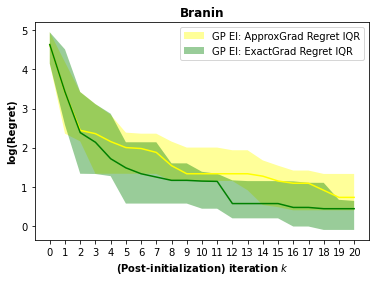

In [97]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Green')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI: ApproxGrad Regret IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Green', alpha=0.4, label='GP EI: ExactGrad Regret IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [98]:
time_approx, time_exact


(759.8705461025238, 3304.633157491684)

In [99]:
np.round(exact_1.acqfunc(x_test)[0],2).reshape(50,10)


array([[-1.13, -1.01, -0.89, -0.77, -0.65, -0.54, -0.43, -0.33, -0.25,
        -0.18],
       [-0.12, -0.07, -0.04, -0.02, -0.01, -0.01, -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.01],
       [-0.01, -0.02, -0.02, -0.03, -0.04, 

In [100]:
np.round(approx_1._acqWrapper(x_test),2).reshape(50,10)


array([[-2.84, -2.62, -2.38, -2.12, -1.84, -1.55, -1.26, -0.96, -0.68,
        -0.43],
       [-0.22, -0.07,  0.01,  0.03,  0.  , -0.06, -0.14, -0.21, -0.25,
        -0.28],
       [-0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 ,
        -0.3 ],
       [-0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.29,
        -0.29],
       [-0.29, -0.29, -0.29, -0.29, -0.29, -0.29, -0.29, -0.29, -0.28,
        -0.28],
       [-0.28, -0.28, -0.28, -0.28, -0.28, -0.28, -0.28, -0.28, -0.28,
        -0.28],
       [-0.28, -0.28, -0.28, -0.28, -0.28, -0.28, -0.28, -0.28, -0.28,
        -0.28],
       [-0.28, -0.28, -0.28, -0.29, -0.29, -0.29, -0.29, -0.29, -0.29,
        -0.29],
       [-0.29, -0.29, -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 ,
        -0.3 ],
       [-0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 ,
        -0.3 ],
       [-0.3 , -0.3 , -0.29, -0.28, -0.26, -0.23, -0.2 , -0.15, -0.1 ,
        -0.06],
       [-0.02,  0.01,  0.03,  0.03,  0.02, 

In [101]:
np.mean(exact_1.acqfunc(x_test)[0]), np.mean(approx_1._acqWrapper(x_test))


(-0.2512536326957021, -0.7672704327090305)

In [102]:
exact_1.acqfunc(x_test)[1].shape


(500, 2)

In [103]:
np.round(exact_1.acqfunc(x_test)[1],2) 


array([[-1.4 , -1.4 ],
       [-1.44, -1.44],
       [-1.46, -1.46],
       [-1.45, -1.45],
       [-1.42, -1.42],
       [-1.35, -1.35],
       [-1.25, -1.25],
       [-1.12, -1.12],
       [-0.97, -0.97],
       [-0.79, -0.79],
       [-0.62, -0.62],
       [-0.45, -0.45],
       [-0.31, -0.31],
       [-0.19, -0.19],
       [-0.11, -0.11],
       [-0.05, -0.05],
       [-0.02, -0.02],
       [-0.01, -0.01],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.

In [104]:
np.mean(exact_1.acqfunc(x_test)[1])


-0.37228711338926307